In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## First Inspection

In [2]:
data = pd.read_parquet("../dat/steam_data.parquet")

### Number of Rows, Columns, Unique Entries

In [3]:
data

,userId,game,action,actionValue
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
...,...,...,...,...
199995,128470551,Titan Souls,play,1.5
199996,128470551,Grand Theft Auto Vice City,purchase,1.0
199997,128470551,Grand Theft Auto Vice City,play,1.5
199998,128470551,RUSH,purchase,1.0


In [4]:
for col in data.columns:
    print(f"Number of unique {col}: {len(data[col].unique())}")

Number of unique userId: 12393
Number of unique game: 5155
Number of unique action: 2
Number of unique actionValue: 1593


Data consists of 200 thousand rows and it have 4 columns, as user id, name of the game, action (play/purchase) and action value (1 if purchase, hours played if play), respectively.  

A simple analysis shows that we have $12393$ unique users and $5155$ unique games in the dataset.  

Maybe it is better if we separate the dataset into two, as puchases and plays.

### Separating the Purchase and Play Data

In [5]:
purchase_data = data.loc[data.action == "purchase"]
play_data = data.loc[data.action != "purchase"]

purchase_data.reset_index(inplace=True, drop=True)
play_data.reset_index(inplace=True, drop=True)

In [6]:
purchase_data.drop(["action", "actionValue"], axis=1, inplace=True)

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
play_data.drop(["action"], axis=1, inplace=True)

In [8]:
purchase_data.to_parquet("../dat/steam_purchase.parquet")
play_data.to_parquet("../dat/steam_play.parquet")

In [9]:
purchase_data.head()

,userId,game
0,151603712,The Elder Scrolls V Skyrim
1,151603712,Fallout 4
2,151603712,Spore
3,151603712,Fallout New Vegas
4,151603712,Left 4 Dead 2


In [10]:
play_data.head()

,userId,game,actionValue
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0
2,151603712,Spore,14.9
3,151603712,Fallout New Vegas,12.1
4,151603712,Left 4 Dead 2,8.9


### Number of Games Users Purchased

In [11]:
number_of_games_df = purchase_data.groupby("userId", as_index=False).count().sort_values(["game"], ascending=False)

In [12]:
number_of_games_df

,userId,game
1729,62990992,1075
784,33865373,783
657,30246419,766
1555,58345543,667
2237,76892907,597
...,...,...
6472,169958335,1
6471,169953184,1
6468,169919297,1
6464,169845810,1


### Summary Statistics for Purchased Games and Game Playtimes

In [13]:
number_of_games_df.game.describe()

count    12393.000000
mean        10.450335
std         35.864269
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       1075.000000
Name: game, dtype: float64

With this, we see that the mean of the purchased games per user in the dataset is $10.45$. However, an interesting thing to note would be some users with a high number of purchased games. If we would like to use the interquartile range to find out the number of outliers, we see that:

$$
IQR = 6 - 1 = 5
$$
$$
1.5 \times IQR = 7.5
$$

Then, any user who bought more than $13.5$ games can be considered outlier in this dataset.

Then, how many of the players here are outliers?:

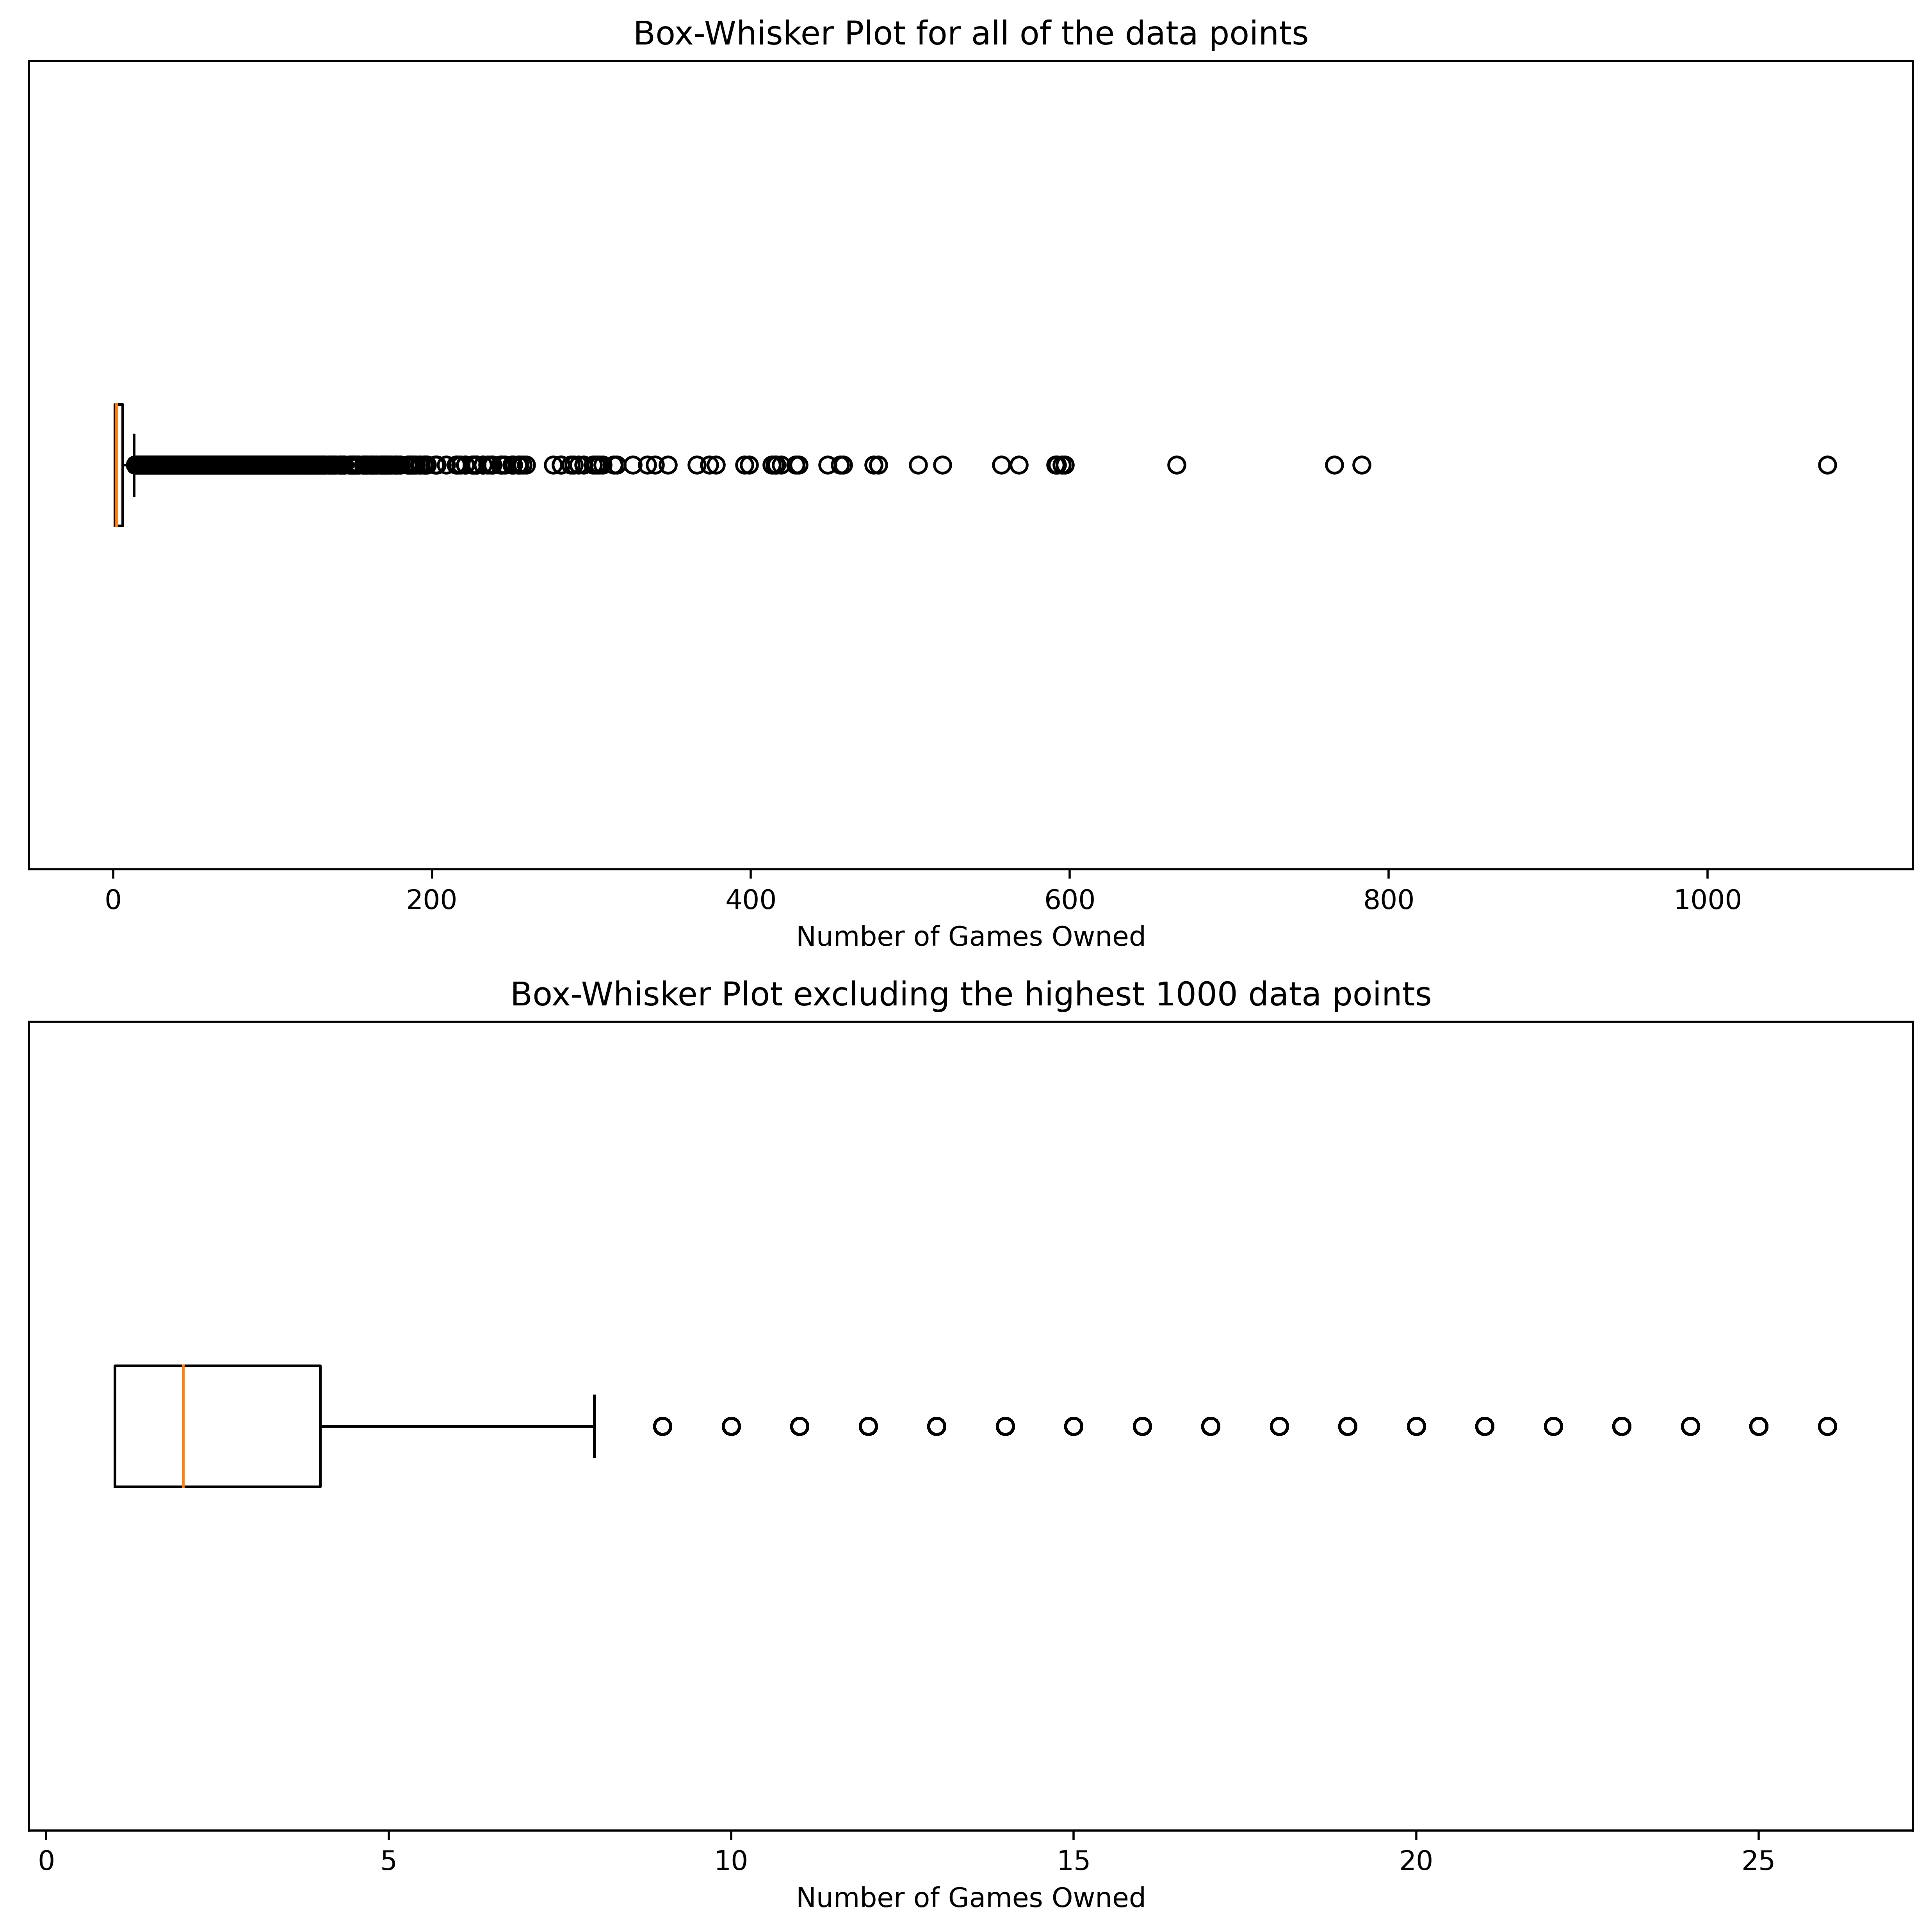

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=500)

ax[0].boxplot(number_of_games_df.game, vert=False)
ax[1].boxplot(number_of_games_df.game[1000:], vert=False)

ax[0].set_title("Box-Whisker Plot for all of the data points")
ax[1].set_title("Box-Whisker Plot excluding the highest 1000 data points")

ax[0].set_xlabel("Number of Games Owned")
ax[1].set_xlabel("Number of Games Owned")

ax[0].set_yticks([])
ax[1].set_yticks([])

fig.tight_layout()
plt.show()

#### Outliers for the Purchased Games

In [70]:
len(number_of_games_df[number_of_games_df.game > 13.5])

1677

It seems that out of $12393$ gamers, $1677$ of them have more than $13.5$ games. This means $13.53\%$ of the players are outliers, and they are increasing the mean.

However, a possible objection to this analysis would be the high number of players whom only purchased one game, which means they are either not on the platform anymore, or they are new users. Thus, they are skewing the number towards them. Let's see how many users have only one game, and out of those how many users played a game for more than $2$ hours, which is the refund limit on Steam.

#### Users who have Bought Only One Game

In [71]:
len(number_of_games_df[number_of_games_df.game == 1])

5693

#### Playtime DataFrame

In [72]:
playtime_df = play_data.groupby("userId", as_index=False).sum().sort_values(["actionValue"], ascending=False)

In [73]:
playtime_df

,userId,actionValue
1810,73017395,11754.0
158,10599862,11651.7
2889,100630947,10853.2
428,26762388,10470.1
5157,153382649,9640.0
...,...,...
4171,130950166,0.1
4755,144307381,0.1
514,29750135,0.1
10512,285316500,0.1


In [74]:
playtime_df.actionValue.describe()

count    11350.000000
mean       303.556458
std        789.541803
min          0.100000
25%          2.300000
50%         19.500000
75%        198.975000
max      11754.000000
Name: actionValue, dtype: float64

### Joining Dataframes

In [75]:
play_and_purchase_df = playtime_df.merge(right=number_of_games_df, how="inner", on="userId")

In [76]:
play_and_purchase_df

,userId,actionValue,game
0,73017395,11754.0,1
1,10599862,11651.7,257
2,100630947,10853.2,10
3,26762388,10470.1,281
4,153382649,9640.0,2
...,...,...,...
11345,130950166,0.1,1
11346,144307381,0.1,1
11347,29750135,0.1,1
11348,285316500,0.1,1


When we do an inner join, we are left with the users that both have purchased a game and played a game on Steam. We have to be careful about here, as there are also free-to-play games on Steam.

In [77]:
play_and_purchase_df = number_of_games_df.merge(right=playtime_df, how="outer", on="userId")

In [78]:
play_and_purchase_df

,userId,game,actionValue
0,62990992,1075,5724.8
1,33865373,783,2274.4
2,30246419,766,1219.7
3,58345543,667,1374.9
4,76892907,597,2731.3
...,...,...,...
12388,169958335,1,5.8
12389,169953184,1,18.0
12390,169919297,1,4.8
12391,169845810,1,0.7


In [79]:
play_and_purchase_df.game.isna().sum()

0

An interesting thing we observe is that even though we used an outer join, all of the users have at least one game purchased. This might mean there are no free games included in this dataset, or that free-to-play games are counted as "purchase" if they are played. To check these, we would need meta-data, which we might do in a future notebook.

Let's see if the users with one game have played their games or not.

### How many Hours Players with One Game Spent

In [80]:
users_one_game = play_and_purchase_df[play_and_purchase_df.game == 1]

In [81]:
users_one_game

,userId,game,actionValue
6700,293364588,1,0.7
6701,295759540,1,9.3
6702,293333924,1,4.4
6703,221035258,1,NaN
6704,293349681,1,10.4
...,...,...,...
12388,169958335,1,5.8
12389,169953184,1,18.0
12390,169919297,1,4.8
12391,169845810,1,0.7


In [82]:
users_one_game.actionValue.describe()

count     5121.000000
mean        73.635032
std        336.392370
min          0.100000
25%          0.900000
50%          3.800000
75%         20.000000
max      11754.000000
Name: actionValue, dtype: float64

In [83]:
users_one_game[users_one_game.actionValue > 1.99].sort_values("actionValue", ascending=False)

,userId,game,actionValue
9703,73017395,1,11754.0
10125,101414179,1,5982.0
10485,93950791,1,5720.0
9211,117106617,1,5229.0
10160,102376253,1,4785.0
...,...,...,...
11868,157362930,1,2.0
7736,265832700,1,2.0
9509,133553031,1,2.0
11883,155793870,1,2.0


Actually, the values are higher than I expected. But we see that out of $5693$ players who have one game, $3149$ of them, which amounts to $55.3\%$ of them, played the game at least once and the median playtime for players with one game is $3.8$ hours. Still, for a better analysis of the outlier players, we can remove players who have not played a game for more than $2$ hours.

In [84]:
new_num_games = number_of_games_df[~number_of_games_df.userId.isin(users_one_game[~(users_one_game.actionValue > 1.99)].userId)]

In [85]:
new_num_games.game.describe()

count    9849.000000
mean       12.891360
std        39.868373
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max      1075.000000
Name: game, dtype: float64

The mean of the number of games a player owns increased to $12.89$. Furthermore, besides for the players who do not actually played a game Steam for a certain period of times, a player who have more than $8 + (1.5\times \ 7) = 18.5$ games is considered an outlier in this dataset.

In [86]:
len(new_num_games[new_num_games.game > 18.5])

1314

In [87]:
len(new_num_games[new_num_games.game > 13.5][new_num_games.game < 18.5])

/tmp/ipykernel_5456/2706201757.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


363

So, when we removed the idle players, we saved $363$ players whom are mistakenly labeled as outliers!

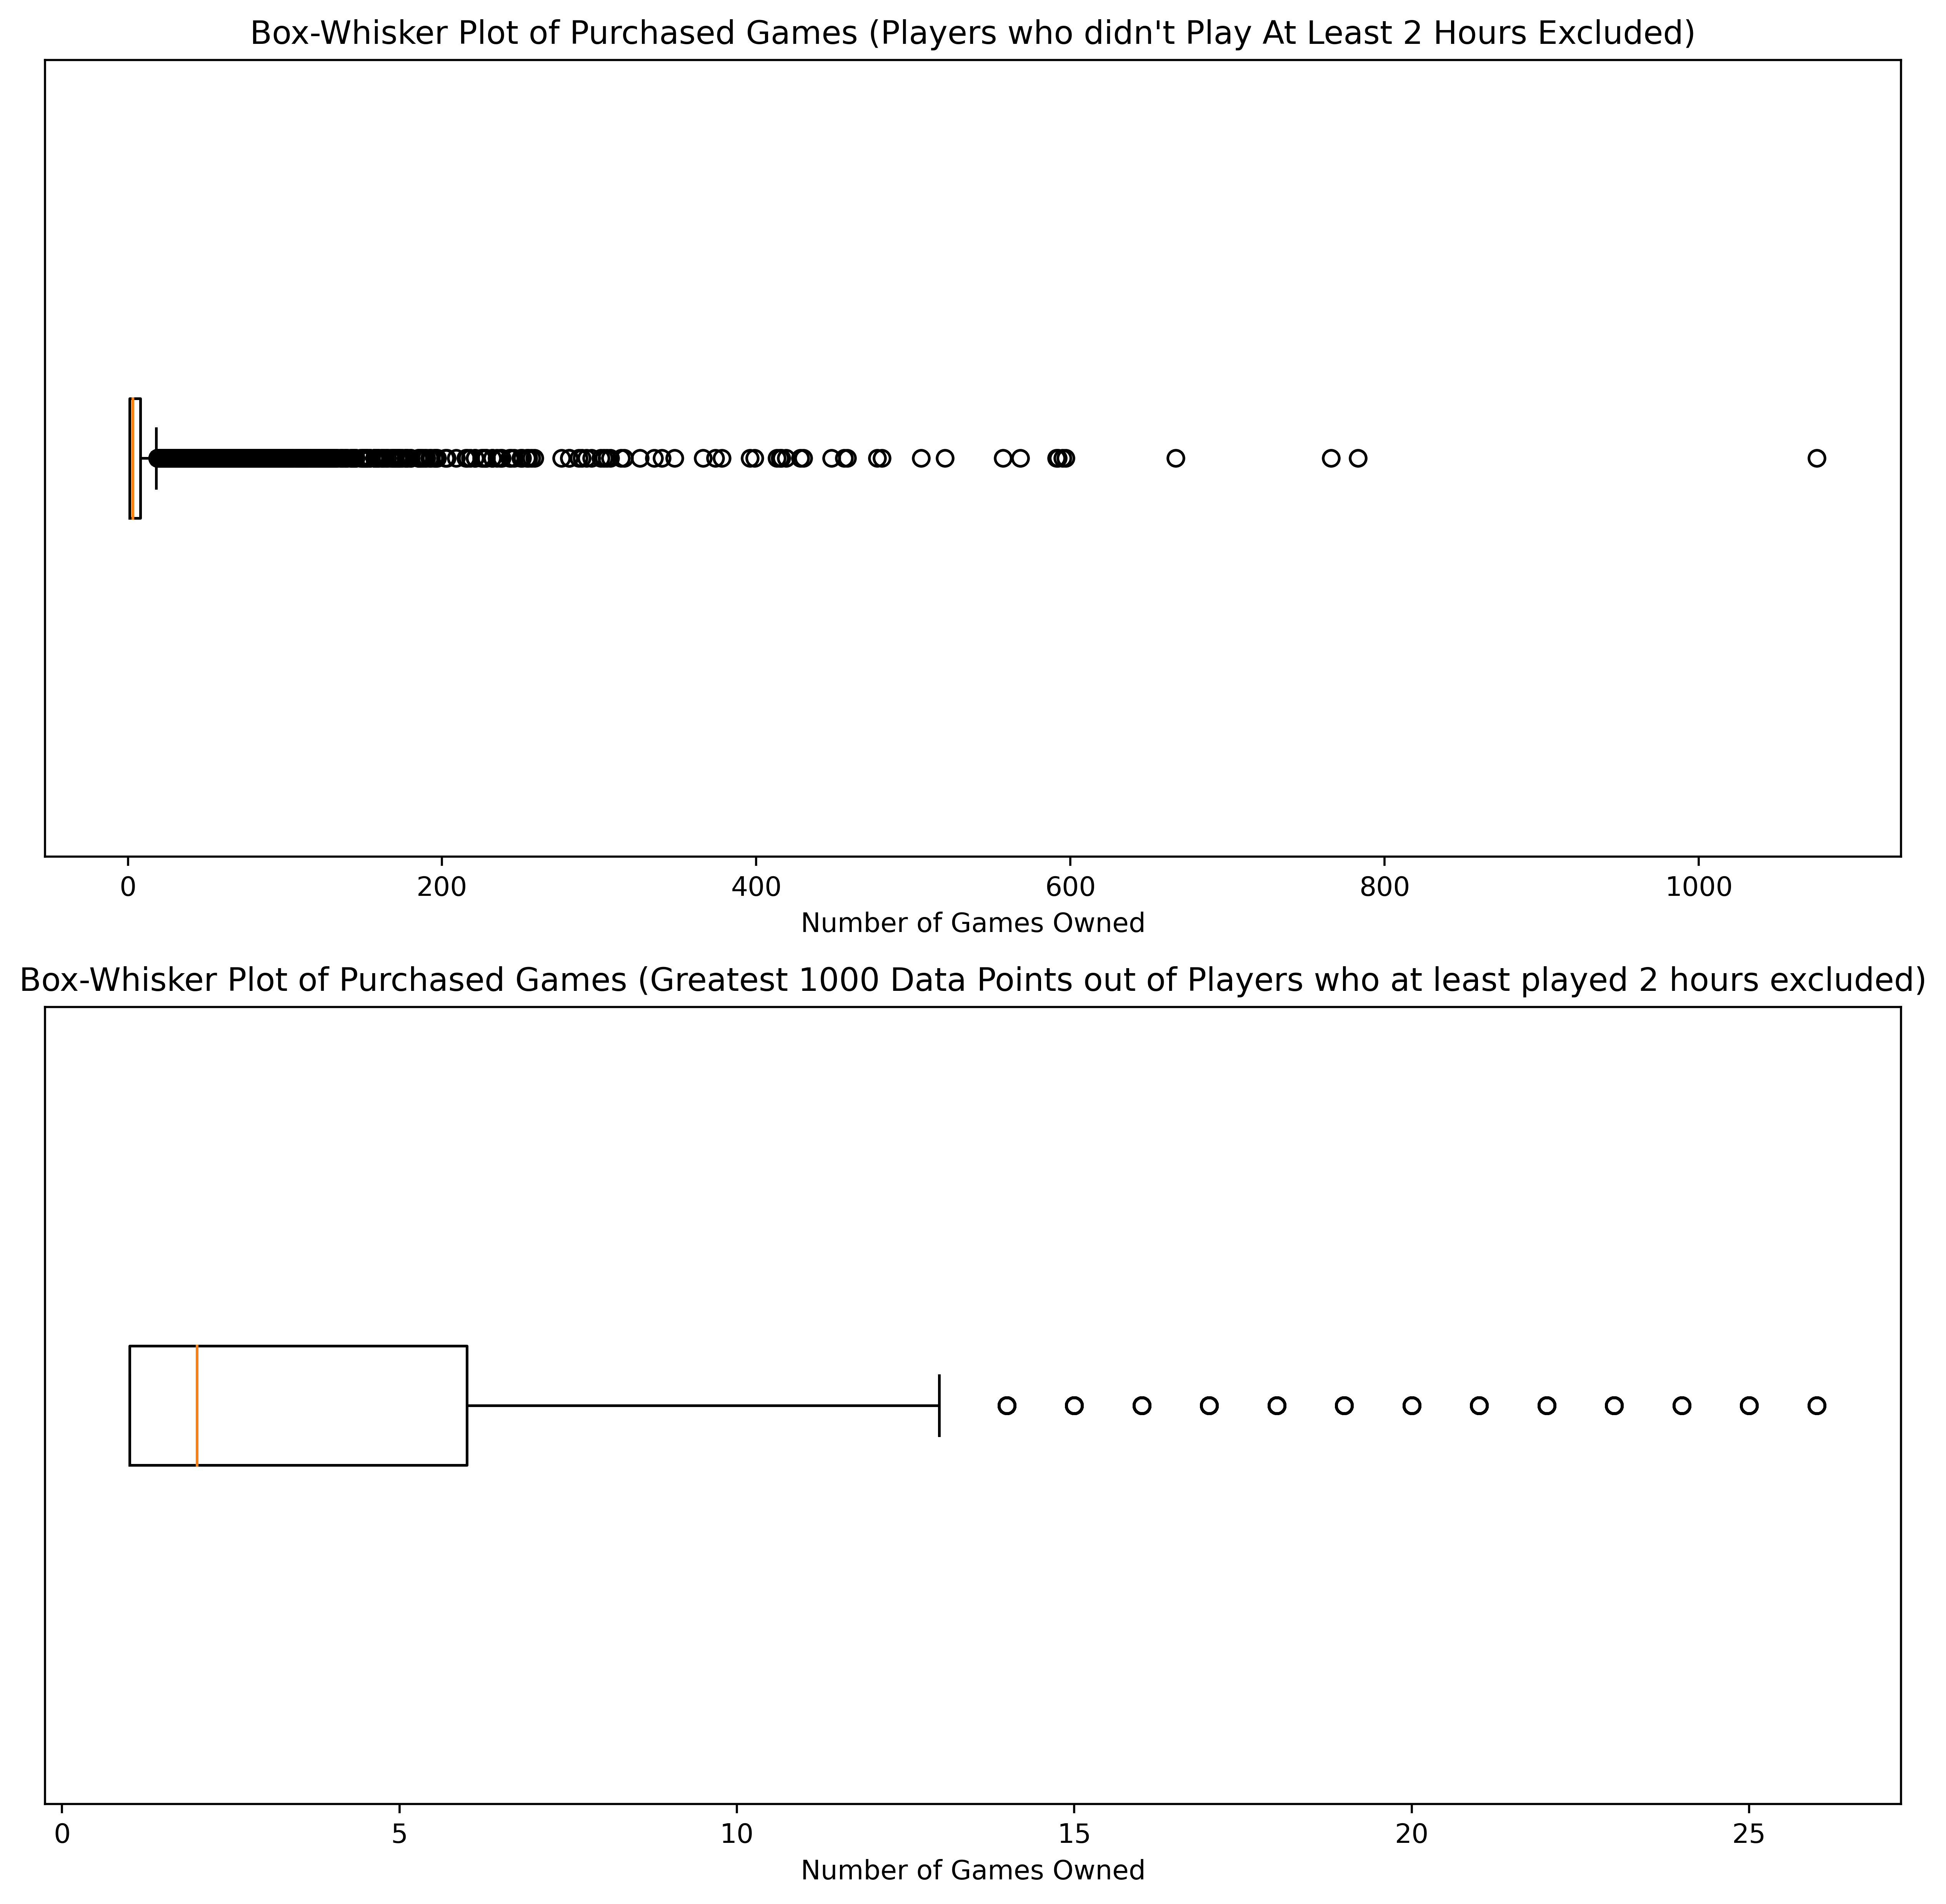

In [90]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=500)

ax[0].boxplot(new_num_games.game, vert=False)
ax[1].boxplot(new_num_games.game[1000:], vert=False)

ax[0].set_title("Box-Whisker Plot of Purchased Games (Players who didn't Play At Least 2 Hours Excluded)")
ax[1].set_title("Box-Whisker Plot of Purchased Games (Greatest 1000 Data Points out of Players who at least played 2 hours excluded)")

ax[0].set_xlabel("Number of Games Owned")
ax[1].set_xlabel("Number of Games Owned")

ax[0].set_yticks([])
ax[1].set_yticks([])

fig.tight_layout()
plt.show()

We can also draw the box plots side by side:

In [99]:
ax.set_yticklabels?

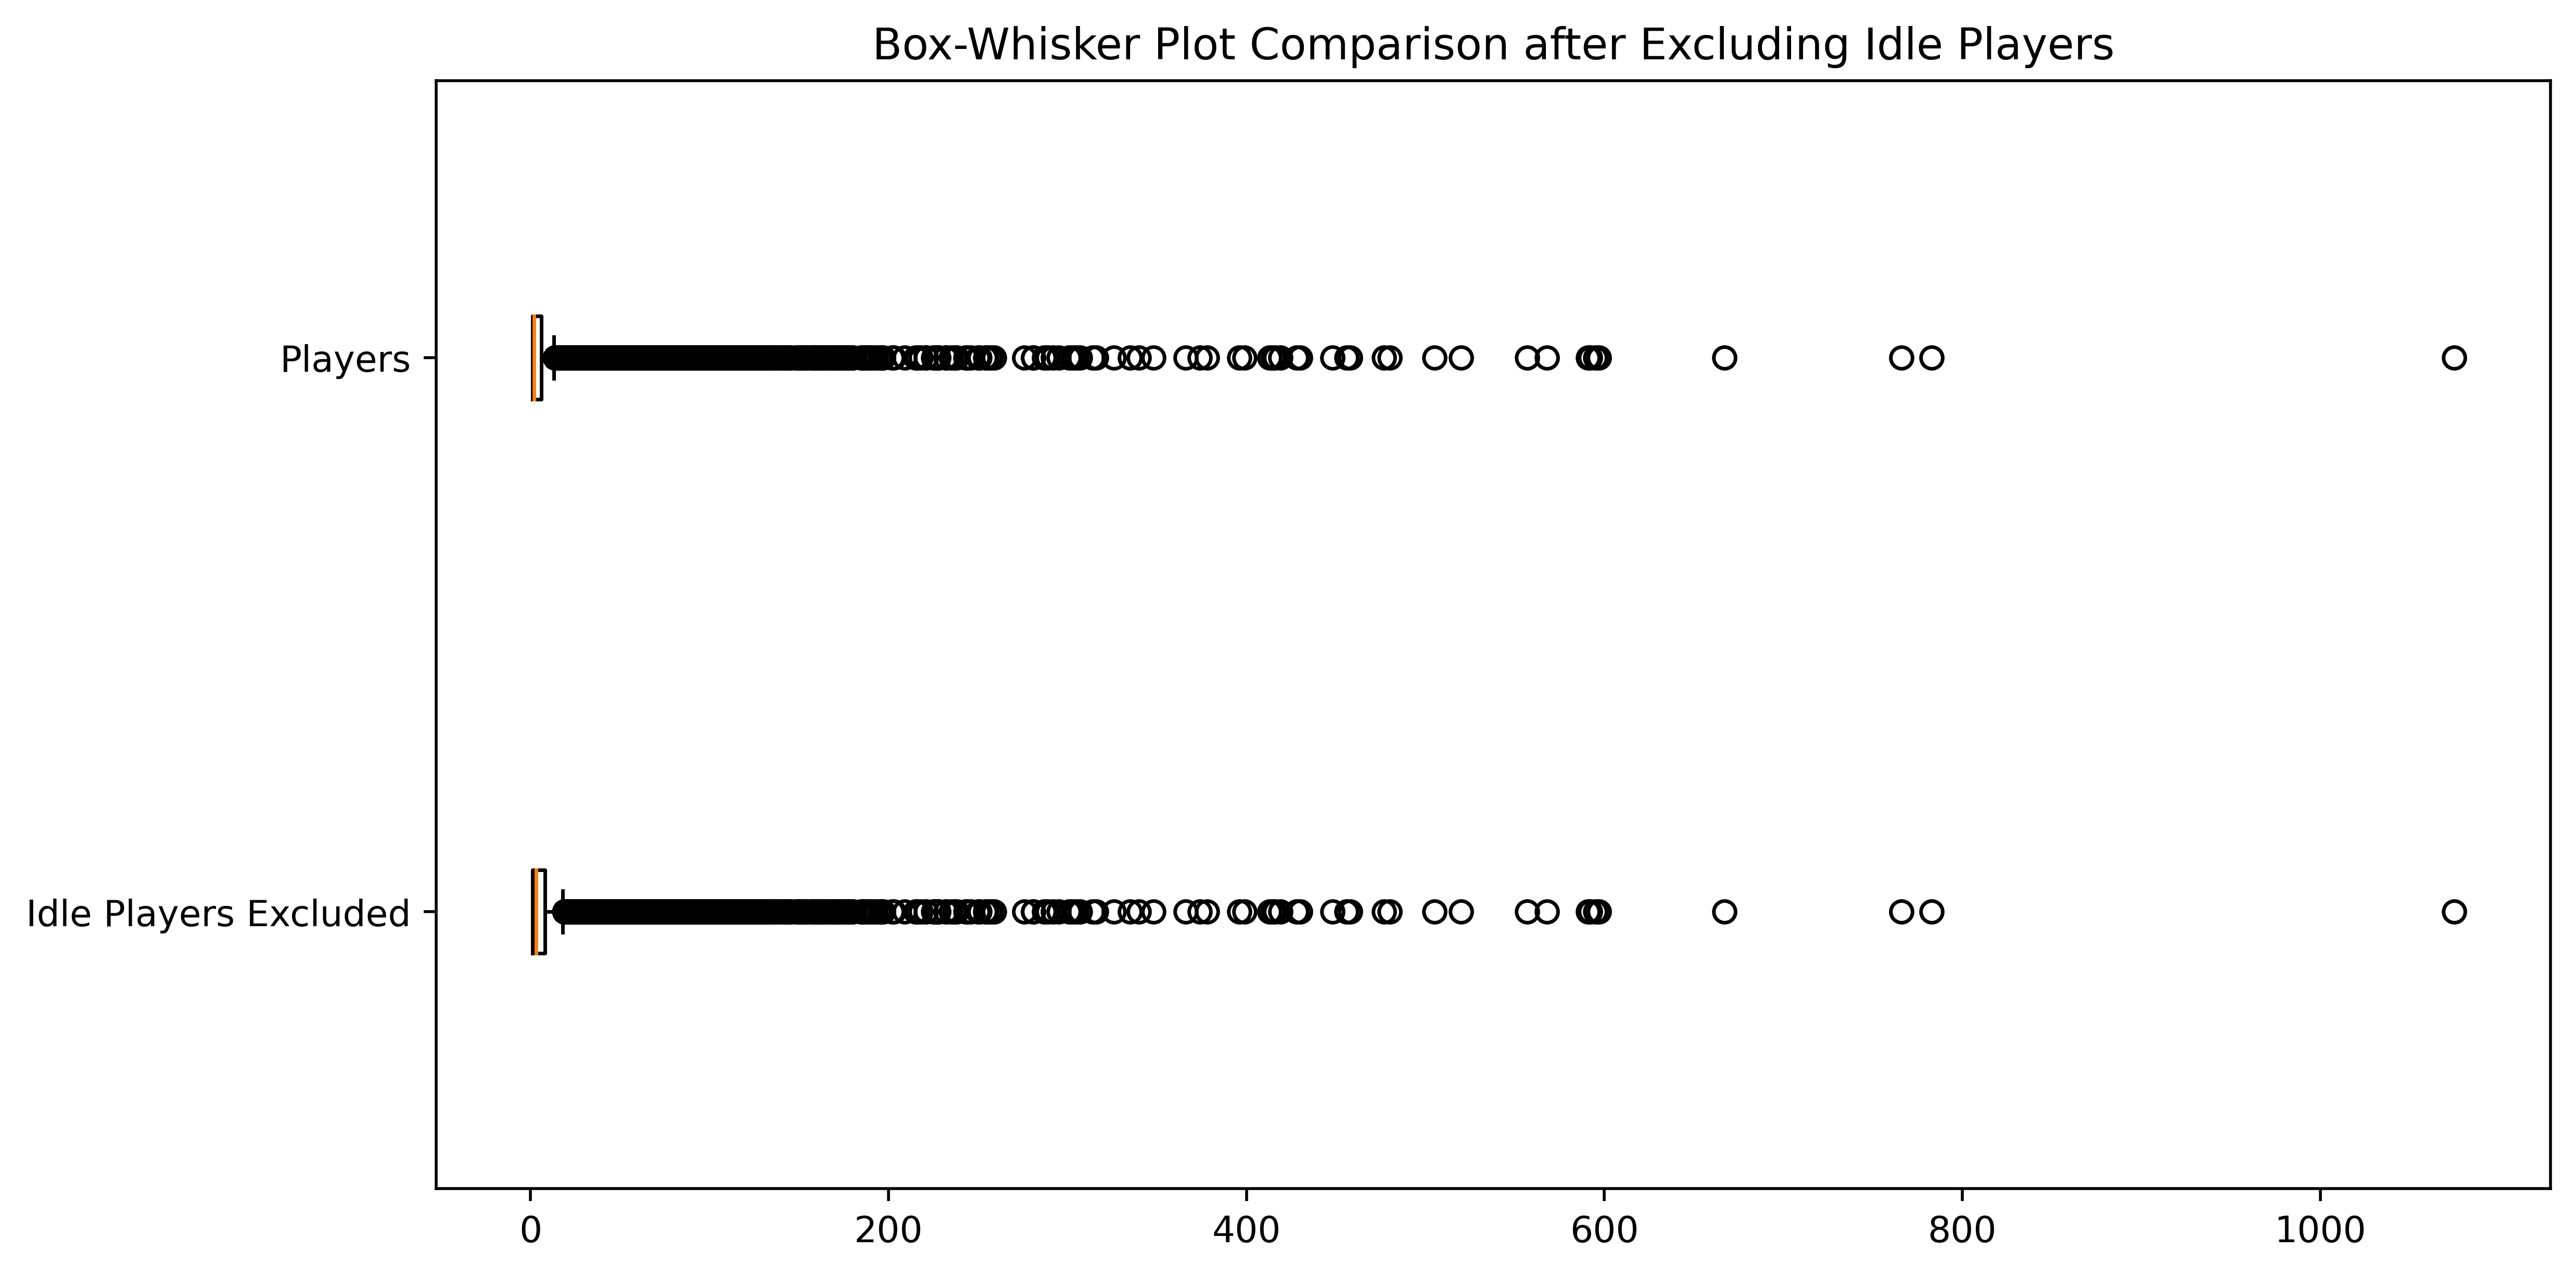

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=500)

ax.boxplot([new_num_games.game, number_of_games_df.game], vert=False)
ax.set_yticklabels(["Idle Players Excluded", "Players"])
ax.set_title("Box-Whisker Plot Comparison after Excluding Idle Players")

fig.tight_layout()
plt.show()

### Outliers for Playtime

A similar analysis can be done for the playtime. Let's remember the summary statistics.

In [104]:
playtime_df.actionValue.describe()

count    11350.000000
mean       303.556458
std        789.541803
min          0.100000
25%          2.300000
50%         19.500000
75%        198.975000
max      11754.000000
Name: actionValue, dtype: float64

The range of the values for playtime is a lot more than the number of games owned. We can similarly compare before and after removing idle players.

In [105]:
playtime_df[playtime_df.actionValue > 1.99].actionValue.describe()

count     8709.000000
mean       395.367103
std        881.026016
min          2.000000
25%         10.500000
50%         54.000000
75%        353.900000
max      11754.000000
Name: actionValue, dtype: float64

For all of the points,

$$
1.5 \times IQR = 1.5 \times (198.975 - 2.3) = 295.0125
$$
$$
198.975 + 295.0125 = 493.9875
$$

Then, players who played video games more than 493.9875 hours while data was being collected are considered outliers.

However, if we remove the idle players, we see that


$$
1.5 \times IQR = 1.5 \times (353.9 - 2.0) = 527.85
$$
$$
353.9 + 527.85 = 881.75
$$

the threshold for being an outlier among Steam players increases to 881.75 hours.

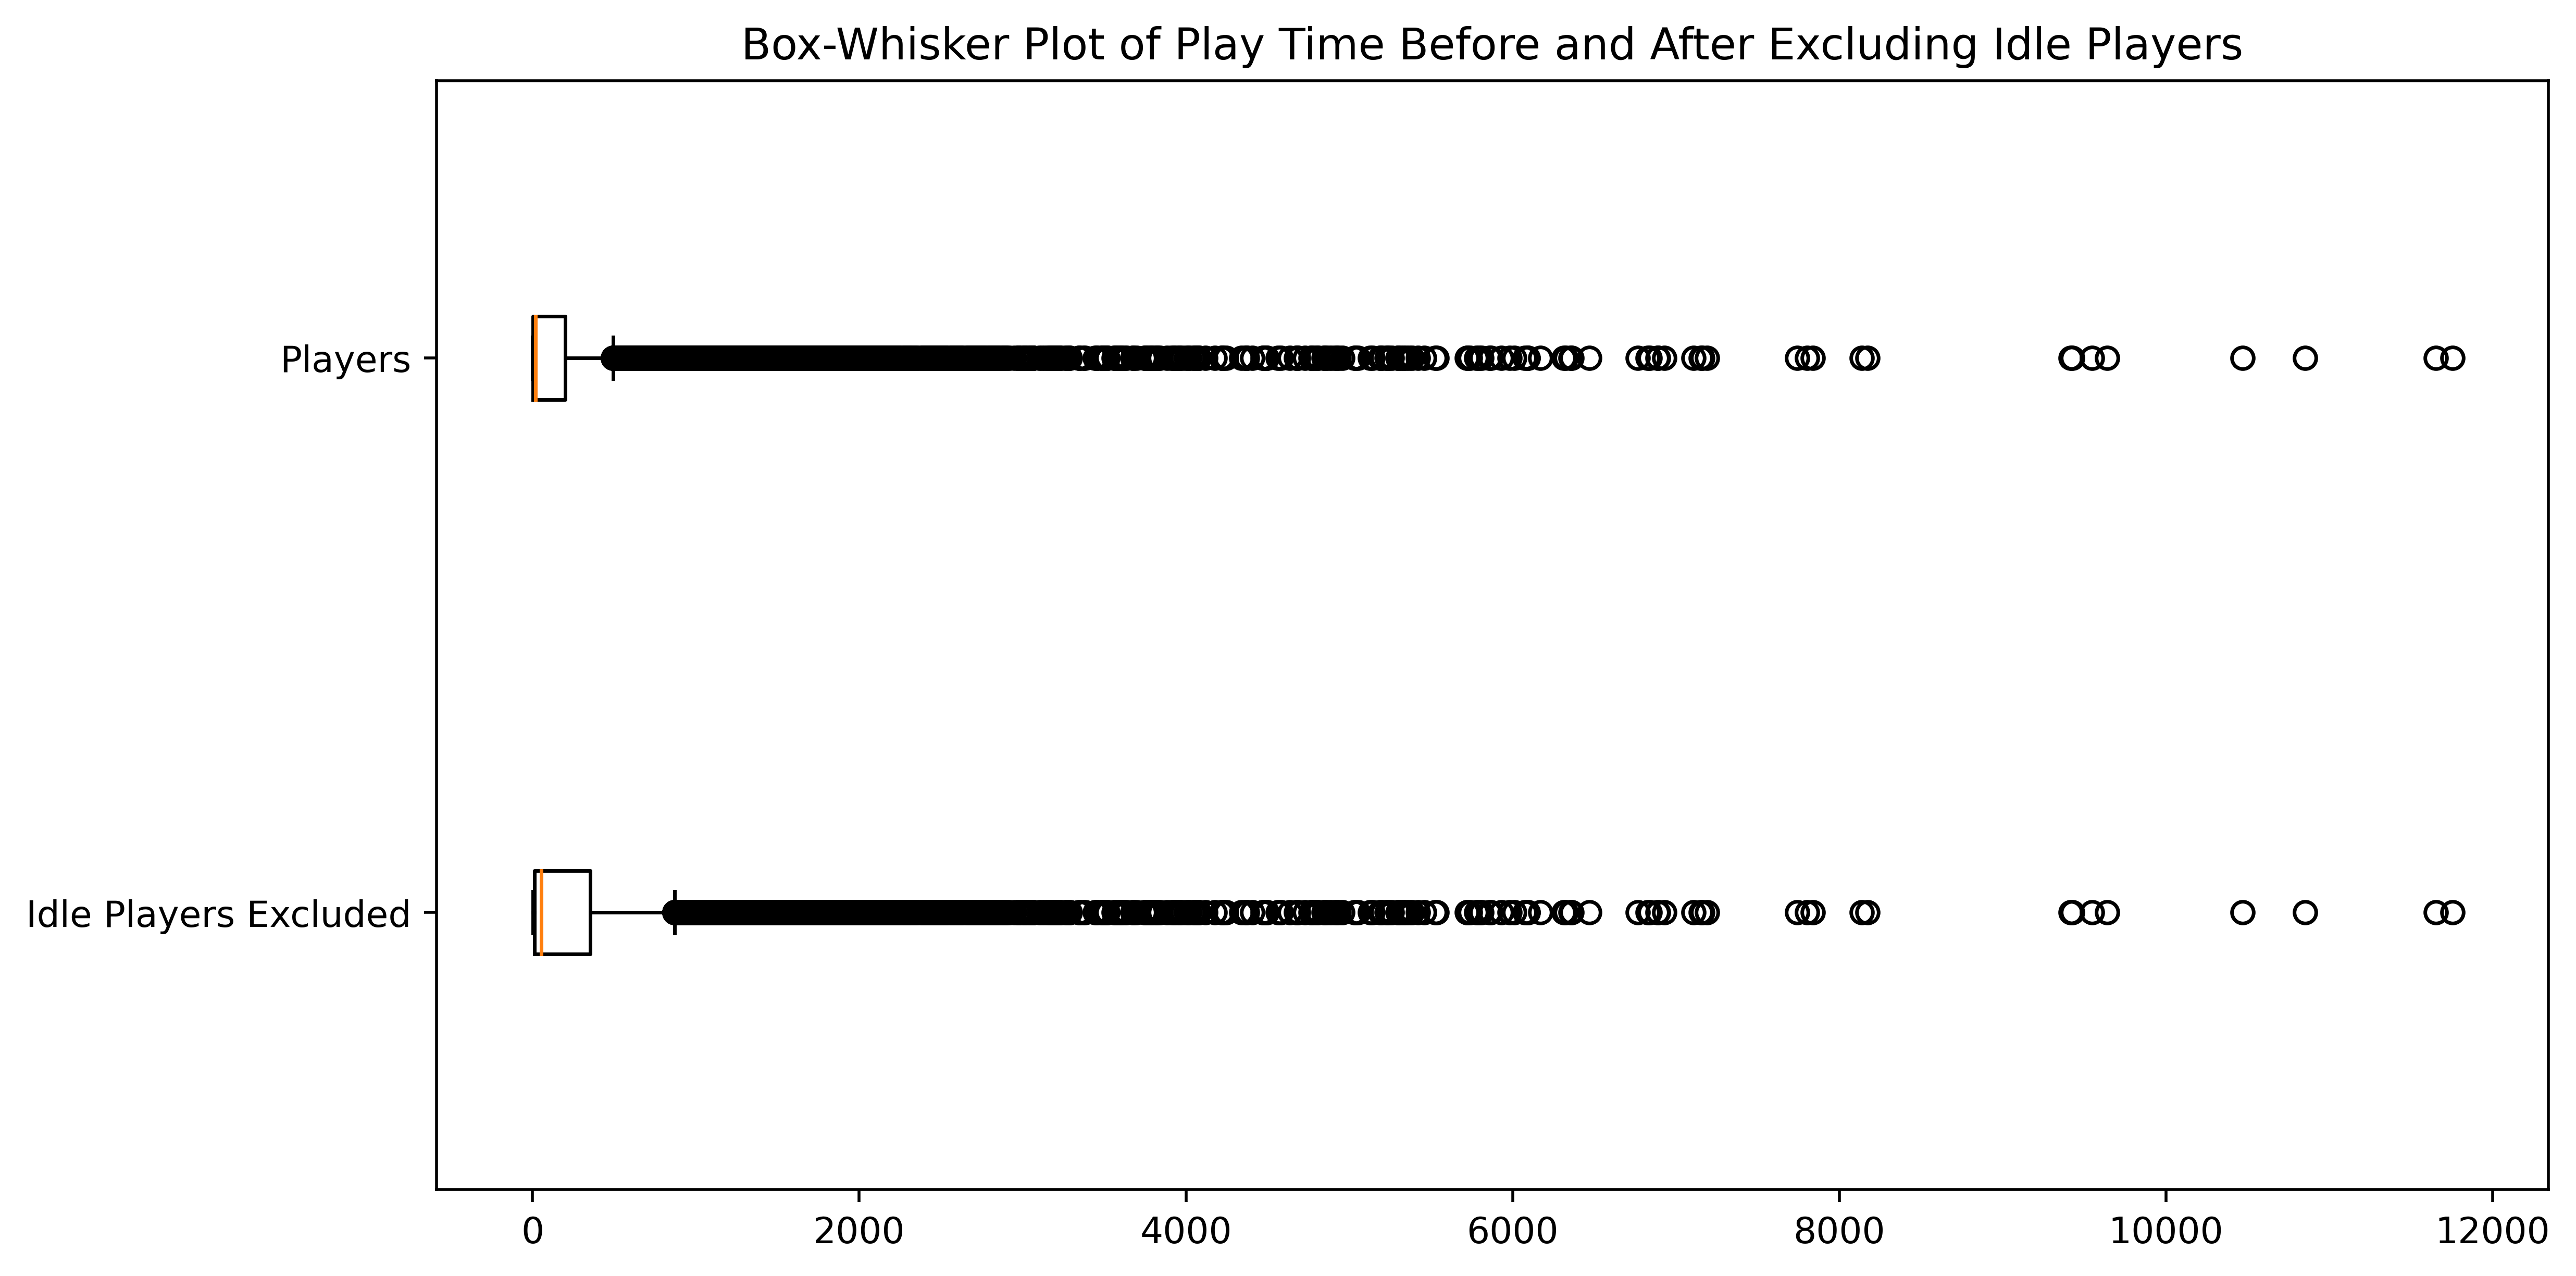

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=500)

ax.boxplot([playtime_df[playtime_df.actionValue > 1.99].actionValue, playtime_df.actionValue], vert=False)
ax.set_yticklabels(["Idle Players Excluded", "Players"])


ax.set_title("Box-Whisker Plot of Play Time Before and After Excluding Idle Players")

fig.tight_layout()
plt.show()